In [1]:
# https://github.com/hananshafi/Image-Augmentation-using-GAN

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys
import os

import numpy as np
import cv2

Specify the data size

In [2]:
img_rows = 100  
img_cols = 100
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

Generator Network

In [3]:
def generatorModel(img_shape, z_dim):
    
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    model.add(Reshape(img_shape))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

Discriminator Network

In [4]:
def discriminator(img_shape):
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

In [5]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generatorModel = generatorModel(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generatorModel(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

GAN Training function

In [6]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise 
    gen_imgs = generatorModel.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [7]:
from pathlib import Path

def get_Xtrain():
    path = "C:\\Users\\labq001\\swin-transformer\\dataset\\bad"

    x_train = []

    for i in os.listdir(path):
        img = cv2.imread(Path(path).joinpath(i), cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (img_rows, img_cols))
        
        x_train.append(resized_img)

    return x_train

In [ ]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    
    # Load the dataset
    X_train = get_Xtrain()
    
    # Rescale -1 to 1
    X_train = np.array(X_train) / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generatorModel.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generatorModel.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            sample_images(iteration)
    return generatorModel

In [9]:
import warnings; warnings.simplefilter('ignore')

GAN Training

0 [D loss: 1.087413, acc.: 30.08%] [G loss: 1.234991]
1000 [D loss: 0.058695, acc.: 100.00%] [G loss: 2.416707]
2000 [D loss: 0.379839, acc.: 83.59%] [G loss: 1.337538]
3000 [D loss: 0.083194, acc.: 98.44%] [G loss: 3.878245]
4000 [D loss: 0.502152, acc.: 84.77%] [G loss: 2.497877]
5000 [D loss: 0.907062, acc.: 31.64%] [G loss: 1.983060]
6000 [D loss: 2.200496, acc.: 0.39%] [G loss: 1.312821]
7000 [D loss: 0.536883, acc.: 79.69%] [G loss: 2.583990]
8000 [D loss: 1.546028, acc.: 0.00%] [G loss: 0.957724]
9000 [D loss: 0.493562, acc.: 85.16%] [G loss: 3.322831]
10000 [D loss: 0.230763, acc.: 91.41%] [G loss: 3.508365]
11000 [D loss: 1.194713, acc.: 31.64%] [G loss: 1.889182]
12000 [D loss: 0.476462, acc.: 72.27%] [G loss: 2.174426]
13000 [D loss: 0.380805, acc.: 94.53%] [G loss: 2.291224]
14000 [D loss: 1.553299, acc.: 7.81%] [G loss: 1.296025]
15000 [D loss: 1.190135, acc.: 6.25%] [G loss: 1.707733]
16000 [D loss: 1.257914, acc.: 3.91%] [G loss: 1.276503]
17000 [D loss: 0.645259, acc.: 

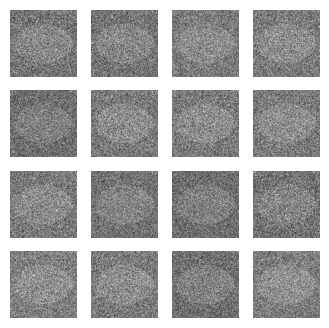

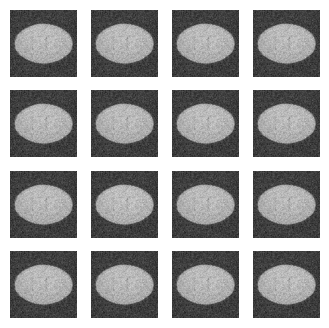

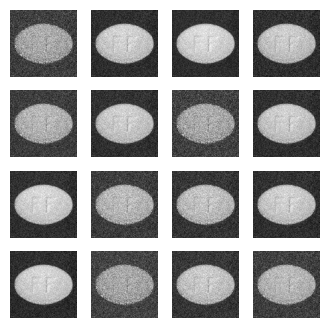

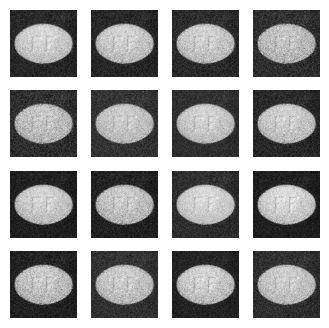

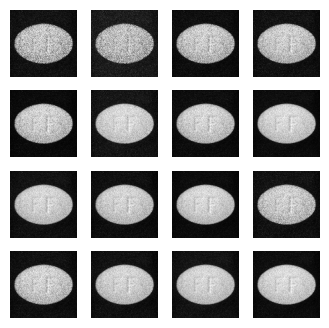

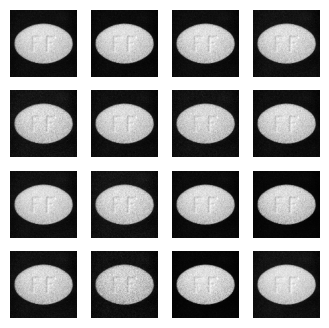

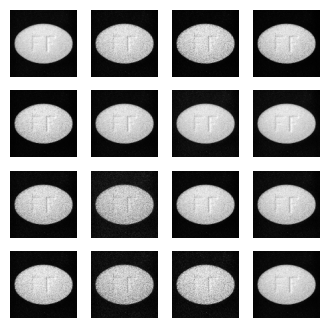

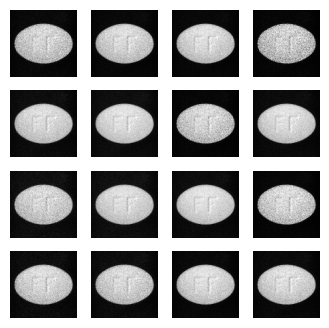

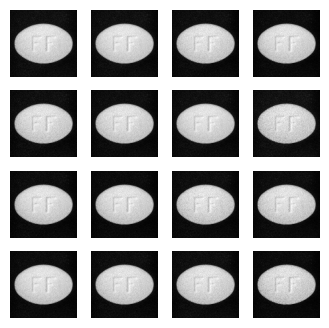

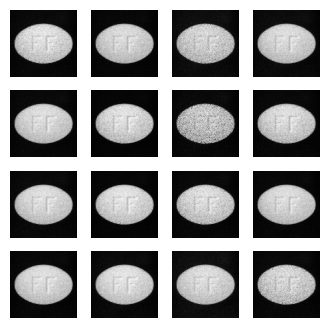

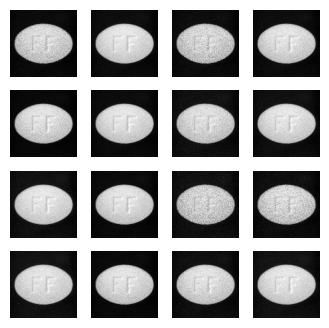

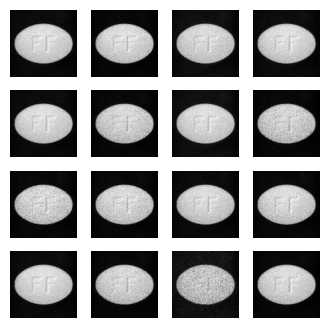

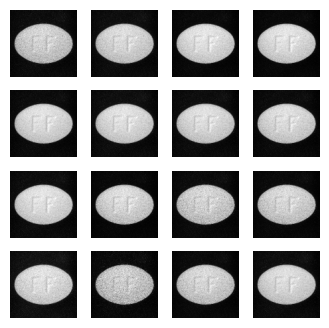

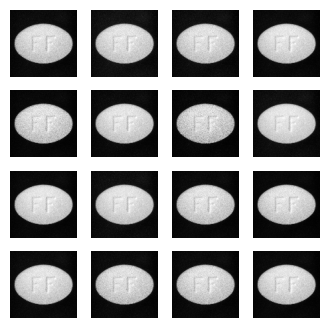

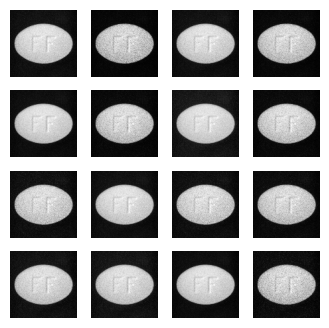

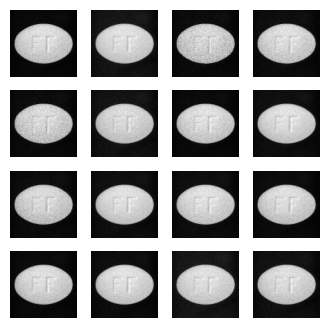

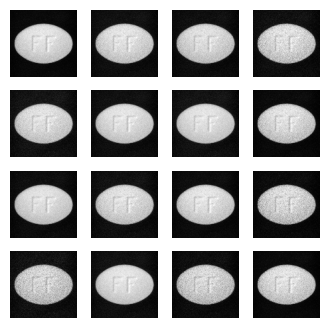

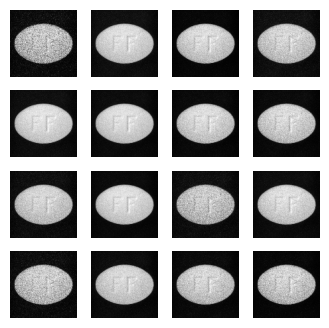

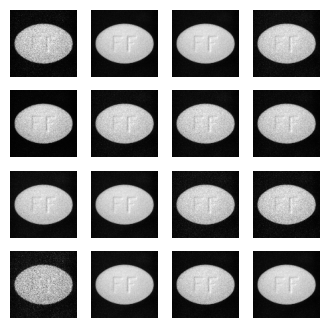

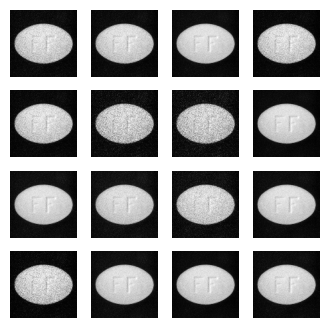

In [ ]:
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
model = train(iterations, batch_size, sample_interval)

In [ ]:
model.save_weights("./model/gan.h5")